In [66]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [67]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser


class ClassifyQuestion(BaseModel):
    """a Boolean value to check whether the question is on topic or not"""
    score : str =Field(
        description = "Question is about proxmox ? If yes -> 'Yes' if not -> 'No"
    )

system = """You are a grader assessing whether a user's question is on-topic.\n
        Only respond if the question is about one of the following topics:
        1. Listing Proxmox node resources (e.g., containers, VMs).
        2. Proxmox node resource management (e.g., updating, deleting, creating).
        3. Listing, setting, or updating Proxmox node resource configurations.

        Examples:
        - How will the weather be today? -> No
        - List VMs on node 'ns31212248' -> Yes
        - Create a VM on node 'Proxmox-Node-HCM' -> Yes

        If the question is about these topics, respond with "Yes"; otherwise, respond with "No".
        """

classify_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: {question}"),
        ]
    )

structured_classifier_llm=llm.with_structured_output(ClassifyQuestion)

classifier_chain = classify_prompt | structured_classifier_llm 


In [68]:
classifier_chain.invoke({
    "question" : "Bella Vista what is it "
})

ClassifyQuestion(score='No')

In [69]:
from langchain_core.messages import (
    BaseMessage,
)
import operator
from typing import Annotated, List,TypedDict


class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str 
    search: str 
    documents: List[str]
    steps: List[str]

In [70]:
def supervisor(state:State):
    question = state["question"]
    result = classifier_chain.invoke({"question":question})
    score=result.score
    if score == "Yes":
        state["search"]="No"
    else:
        state["search"]="Yes"
    print(f"QUESTION and GRADE: {question} - {result.score}")
    return state 
        

In [71]:
state ={
    "question" : "What's Bella Vista" , 
    "generation" :"",
    "search" : "No",
    "documents" : [],
    "steps":[]
}

supervisor(state)

QUESTION and GRADE: What's Bella Vista - No


{'question': "What's Bella Vista",
 'generation': '',
 'search': 'Yes',
 'documents': [],
 'steps': []}

In [72]:
from langfuse.callback import CallbackHandler
import os
from dotenv import load_dotenv

load_dotenv()

True

In [73]:
langfuse_handler = CallbackHandler(
    public_key=os.getenv('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.getenv('LANGFUSE_SECRET_KEY'),
    host=os.getenv('LANGFUSE_HOST'),
)

In [74]:
from langserve_app.app import compiled_graph

In [75]:
compiled_graph.invoke({
            "messages": ["list Vms on node 'ns31212248'"],
            "next": None,
            "team_members": []
        }, config={"callbacks": [langfuse_handler]})

processing_request: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': [], 'next': None}
proxmox_router: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'], 'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM / Proxmox-Node-HCM
https://ns31418912.ip-54-38-37.eu:8006/


{'messages': ["list Vms on node 'ns31212248'",
  {'question': "list Vms on node 'ns31212248'",
   'output': "The API request to list VMs on node 'ns31212248' failed with a 500 error due to a hostname lookup failure. The node 'ns31212248' could not be found."}],
 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'],
 'next': 'Proxmox-Node-HCM'}

In [76]:
def proxmox_agent_call(state:State):
    question=state["question"]
    result= compiled_graph.invoke({
            "messages": [question],
            "next": None,
            "team_members": []
        }, config={"callbacks": [langfuse_handler]})
    state["generation"] = result
    steps = state ["steps"]
    steps.append("calling proxmox agent")
    return state 

In [77]:
state ={
    "question" : "list Vms on node 'ns31212248'" , 
    "generation" :"",
    "search" : "No",
    "documents" : [],
    "steps":[]
}

proxmox_agent_call(state)

processing_request: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': [], 'next': None}
proxmox_router: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'], 'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM / Proxmox-Node-HCM
https://ns31418912.ip-54-38-37.eu:8006/


{'question': "list Vms on node 'ns31212248'",
 'generation': {'messages': ["list Vms on node 'ns31212248'",
   {'question': "list Vms on node 'ns31212248'",
    'output': "The API request to list VMs on node 'ns31212248' failed with a 500 error due to a hostname lookup failure."}],
  'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'],
  'next': 'Proxmox-Node-HCM'},
 'search': 'No',
 'documents': [],
 'steps': ['calling proxmox agent']}

In [78]:
from langchain_community.utilities import SearxSearchWrapper

searchX = SearxSearchWrapper(searx_host="http://localhost:8080" , k=3)

In [79]:
import pprint

result = searchX.run("Obama's first name?",engines=["wiki"])
pprint.pp(result)

('[15] [18] His last name, Obama, was derived from his Luo descent. [19] '
 "Obama's parents met in 1960 in a Russian language class at the University of "
 "Hawaiʻi at Mānoa, ... During Obama's first presidential campaign in May "
 "2008, he resigned from Trinity after some of Wright's statements were "
 'criticized. [110] Since moving to Washington, ...\n'
 '\n'
 'Barack Obama (born August 4, 1961, Honolulu, Hawaii, U.S.) is the 44th '
 'president of the United States (2009–17) and the first African American to '
 'hold the office. Before winning the presidency, Obama represented Illinois '
 'in the U.S. Senate (2005–08). He was the third African American to be '
 'elected to that body since the end of ...\n'
 '\n'
 "July 26, 2015 - See the President's daily schedule, explore "
 'behind-the-scenes photos from inside the White House, and find out all the '
 'ways you can engage with the most interactive administration in our '
 "country's history.")


In [80]:
import pprint

results = searchX .results(
    "Obama's first name?",
    num_results=5,
    categories="general",
    time_range="year",
)
pprint.pp(results)

[{'snippet': '1 week ago - Barack Obama graduated from Punahou School, an '
             'elite academy in Honolulu, and then attended Occidental College '
             'before transferring to Columbia University and earning (1983) a '
             'B.A. in political science. He graduated (1991) magna cum laude '
             'from Harvard University’s law school and was the first ...',
  'title': 'Barack Obama | Biography, Parents, Education ...',
  'link': 'https://www.britannica.com/biography/Barack-Obama',
  'engines': ['brave', 'duckduckgo', 'google'],
  'category': 'general'},
 {'snippet': '2 days ago - The selection was slow because ... it was reported '
             'that the Obamas had adopted a six-month-old Portuguese Water Dog '
             'given to them as a gift by Senator Ted Kennedy; Malia and Sasha '
             'named the dog Bo. The White House referred to Bo as the First '
             'Dog....',
  'title': 'Family of Barack Obama',
  'link': 'https://en.wikipedi

In [81]:
def web_search(state: State):
    question = state['question']
    result = searchX.run(question)
    documents = state['documents']
    documents.append(result)
    steps = state['steps']
    steps.append("web search")
    return state

In [82]:
def off_topic_router(state:State):
    search = state['search']
    if search == "Yes" : 
        return "web search"
    else :
        return "proxmox agent"

In [83]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(State)
workflow.add_node("supervisor",supervisor)
workflow.add_node("proxmox agent", proxmox_agent_call)
workflow.add_node("web search", web_search)


workflow.add_edge("proxmox agent",END)
workflow.add_edge("web search",END)
workflow.add_conditional_edges(
                              "supervisor",
                               off_topic_router,
                               {
                                   "web search":"web search",
                                   "proxmox agent" : "proxmox agent"
                                }
                              )

workflow.set_entry_point("supervisor")

app = workflow.compile()

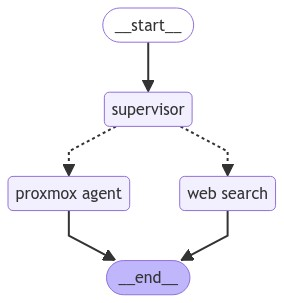

In [84]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [85]:

app.invoke({
    "question" : "list Vms on node 'ns31212248'" , 
    "generation" :"",
    "search" : "",
    "documents" : [],
    "steps":[]
}, config={"callbacks": [langfuse_handler]})

QUESTION and GRADE: list Vms on node 'ns31212248' - Yes
processing_request: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': [], 'next': None}
proxmox_router: Current state: {'messages': ["list Vms on node 'ns31212248'"], 'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'], 'next': 'Proxmox-Node-HCM'}
Proxmox-Node-HCM / Proxmox-Node-HCM
https://ns31418912.ip-54-38-37.eu:8006/


{'question': "list Vms on node 'ns31212248'",
 'generation': {'messages': ["list Vms on node 'ns31212248'",
   {'question': "list Vms on node 'ns31212248'",
    'output': "The API request to list VMs on node 'ns31212248' failed with a 500 error due to a hostname lookup failure. The node 'ns31212248' could not be found."}],
  'team_members': ['Proxmox-Node-HCM', 'ns31212248', 'coral-io-proxmox-lab'],
  'next': 'Proxmox-Node-HCM'},
 'search': 'No',
 'documents': [],
 'steps': ['calling proxmox agent']}